In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Sequential, Model
from keras.models import model_from_json
from tensorflow import keras
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df1 = pd.read_pickle("../Data/returns.pkl").iloc[1:]

drop_columns = []
for col in df1.columns:
    if df1[col].isnull().all() == True:
        drop_columns.append(col)
        
df1.drop(columns=drop_columns, inplace=True)

In [3]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df1.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [4]:
df1 = get_investable(pd.to_datetime('2018-05-11'),500)

In [5]:
tts = train_test_split(df1, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [6]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

In [7]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# normalized with a MinMaxScaler to the range [0,1].

epochs = 250
batch_size = 1024

class simple_autoencoder():
    
    def __init__(self):
        pass
    
    def reduced_dim(self):
        encoding_dim = 20
        window_length = training_set_scaled.shape[1]
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # model mapping an input to its encoded representation
        encoder = Model(input_window, encoded)
        return pd.DataFrame(encoder.predict(test_set_scaled)).head()

    def model(self,optimizer = "Adam", score = 'acc', loss = "mean_squared_error", epochs = 250, dim = 20):
        encoding_dim = dim
        window_length = training_set_scaled.shape[1]
        # input placeholder
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # lossy reconstruction of the input
        decoded = Dense(window_length, activation='linear')(encoded) #linear
        # model mapping an input to its reconstruction
        simple_autoencoder = Model(input_window, decoded)
        simple_autoencoder.summary()
        sae = simple_autoencoder.compile(optimizer=optimizer, loss=loss, metrics=score) #MSE
        return simple_autoencoder

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto', verbose = 1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",save_best_only=True)


model = simple_autoencoder()
history = model.model().fit(training_set_scaled, training_set_scaled,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split = 0.2,
                    callbacks = [monitor, checkpointer])       
#                   validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = simple_autoencoder().model().predict(test_set_scaled)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 644)]             0         
_________________________________________________________________
dense (Dense)                (None, 20)                12900     
_________________________________________________________________
dense_1 (Dense)              (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1/1 [==============================] - 17s 17s/step - loss: 0.2845 - acc: 0.0000e+00 - val_loss: 0.2741 - val_acc: 0.0000e+00
Epoch 2/250
1/1 [==============================] - 0s 51ms/step - loss: 0.2695 - acc: 0.0000e+00 - val_loss: 0.2654 - val_acc: 0.0000e+00
Epoch 3/250
1/1 [==============================] - 0s 66ms/step - loss: 0.2608 - acc: 0.0000e+00 - val_loss: 0.

Epoch 56/250
1/1 [==============================] - 0s 50ms/step - loss: 0.0110 - acc: 0.1875 - val_loss: 0.0129 - val_acc: 0.1500
Epoch 57/250
1/1 [==============================] - 0s 45ms/step - loss: 0.0109 - acc: 0.1875 - val_loss: 0.0128 - val_acc: 0.1500
Epoch 58/250
1/1 [==============================] - 0s 37ms/step - loss: 0.0108 - acc: 0.1875 - val_loss: 0.0128 - val_acc: 0.1500
Epoch 59/250
1/1 [==============================] - 0s 37ms/step - loss: 0.0108 - acc: 0.1875 - val_loss: 0.0127 - val_acc: 0.1500
Epoch 60/250
1/1 [==============================] - 0s 41ms/step - loss: 0.0107 - acc: 0.1875 - val_loss: 0.0126 - val_acc: 0.1500
Epoch 61/250
1/1 [==============================] - 0s 46ms/step - loss: 0.0106 - acc: 0.1875 - val_loss: 0.0126 - val_acc: 0.1500
Epoch 62/250
1/1 [==============================] - 0s 40ms/step - loss: 0.0105 - acc: 0.1875 - val_loss: 0.0125 - val_acc: 0.1500
Epoch 63/250
1/1 [==============================] - 0s 47ms/step - loss: 0.0105 - a

1/1 [==============================] - 0s 49ms/step - loss: 0.0096 - acc: 0.1875 - val_loss: 0.0118 - val_acc: 0.1500
Epoch 119/250
1/1 [==============================] - 0s 56ms/step - loss: 0.0096 - acc: 0.1875 - val_loss: 0.0118 - val_acc: 0.1500
Epoch 120/250
1/1 [==============================] - 0s 40ms/step - loss: 0.0095 - acc: 0.1875 - val_loss: 0.0118 - val_acc: 0.1500
Epoch 121/250
1/1 [==============================] - 0s 46ms/step - loss: 0.0095 - acc: 0.1875 - val_loss: 0.0118 - val_acc: 0.1500
Epoch 122/250
1/1 [==============================] - 0s 40ms/step - loss: 0.0095 - acc: 0.1875 - val_loss: 0.0118 - val_acc: 0.1500
Epoch 123/250
1/1 [==============================] - 0s 69ms/step - loss: 0.0095 - acc: 0.1875 - val_loss: 0.0118 - val_acc: 0.1500
Epoch 124/250
1/1 [==============================] - 0s 62ms/step - loss: 0.0095 - acc: 0.1875 - val_loss: 0.0118 - val_acc: 0.1500
Epoch 125/250
1/1 [==============================] - 0s 44ms/step - loss: 0.0095 - acc: 0.

1/1 [==============================] - 0s 49ms/step - loss: 0.0088 - acc: 0.1750 - val_loss: 0.0112 - val_acc: 0.1500
Epoch 181/250
1/1 [==============================] - 0s 81ms/step - loss: 0.0088 - acc: 0.1750 - val_loss: 0.0112 - val_acc: 0.1500
Epoch 182/250
1/1 [==============================] - 0s 59ms/step - loss: 0.0088 - acc: 0.1750 - val_loss: 0.0112 - val_acc: 0.1500
Epoch 183/250
1/1 [==============================] - 0s 57ms/step - loss: 0.0088 - acc: 0.1750 - val_loss: 0.0112 - val_acc: 0.1500
Epoch 184/250
1/1 [==============================] - 0s 55ms/step - loss: 0.0087 - acc: 0.1750 - val_loss: 0.0112 - val_acc: 0.1500
Epoch 185/250
1/1 [==============================] - 0s 45ms/step - loss: 0.0087 - acc: 0.1750 - val_loss: 0.0112 - val_acc: 0.1500
Epoch 186/250
1/1 [==============================] - 0s 41ms/step - loss: 0.0087 - acc: 0.1750 - val_loss: 0.0112 - val_acc: 0.1500
Epoch 187/250
1/1 [==============================] - 0s 41ms/step - loss: 0.0087 - acc: 0.

1/1 [==============================] - 0s 81ms/step - loss: 0.0084 - acc: 0.1719 - val_loss: 0.0109 - val_acc: 0.1500
Epoch 243/250
1/1 [==============================] - 0s 101ms/step - loss: 0.0084 - acc: 0.1719 - val_loss: 0.0109 - val_acc: 0.1500
Epoch 244/250
1/1 [==============================] - 0s 52ms/step - loss: 0.0084 - acc: 0.1719 - val_loss: 0.0109 - val_acc: 0.1500
Epoch 245/250
1/1 [==============================] - 0s 66ms/step - loss: 0.0084 - acc: 0.1719 - val_loss: 0.0109 - val_acc: 0.1500
Epoch 246/250
1/1 [==============================] - 0s 66ms/step - loss: 0.0084 - acc: 0.1719 - val_loss: 0.0109 - val_acc: 0.1500
Epoch 247/250
1/1 [==============================] - 0s 56ms/step - loss: 0.0084 - acc: 0.1719 - val_loss: 0.0109 - val_acc: 0.1500
Epoch 248/250
1/1 [==============================] - 0s 57ms/step - loss: 0.0084 - acc: 0.1719 - val_loss: 0.0109 - val_acc: 0.1500
Epoch 249/250
1/1 [==============================] - 0s 51ms/step - loss: 0.0084 - acc: 0

In [8]:
simple_autoencoder().reduced_dim()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.729126,-0.130252,-0.524951,-0.090636,0.092519,0.249792,-0.688848,0.253849,-0.855286,0.316461,-0.657050,-0.131211,-0.411097,0.263080,-0.532038,0.493322,0.144703,-0.563939,-0.091526,0.332167
1,-0.793685,0.462982,-0.420577,-0.189868,0.272670,-0.502306,-0.466145,-0.134317,-0.904030,-0.160679,-0.805807,0.029791,-0.416712,0.493050,-0.410700,0.436992,0.278548,-0.632415,-0.559519,0.577758
2,-0.828277,0.019605,-0.564242,0.051519,-0.190512,-0.384274,-0.785958,-0.031151,-0.908572,-0.109035,-0.774688,0.034641,-0.111469,0.235366,-0.302815,0.249170,0.308550,-0.590286,-0.003588,0.100507
3,-0.698669,0.114277,-0.391740,0.172948,-0.089396,-0.134542,-0.733552,-0.353536,-0.903725,0.051106,-0.709713,0.075412,-0.019195,0.153585,-0.453903,0.295705,-0.150669,-0.706878,-0.254142,0.299451
4,-0.729184,0.284199,-0.380451,-0.247780,-0.089781,-0.392786,-0.518355,-0.141939,-0.701978,0.023395,-0.697917,-0.002348,-0.022296,0.149898,-0.513363,0.239871,-0.131888,-0.404208,-0.055704,0.401373


In [9]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 4, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    ax = plt.subplot(1, 4, 3)
    plt.plot(history.history["val_acc"])
    plt.title("Accuracy")

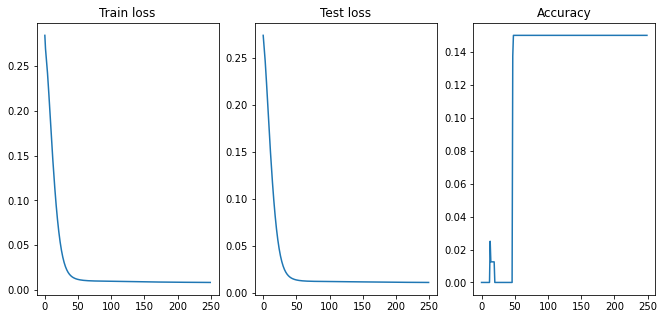

In [10]:
# Loss vs Epoch
plot_history(history)

## Hyperparameter Tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

model_regressor = KerasRegressor(simple_autoencoder().model, verbose=1, batch_size=10, epochs=10)

#define the grid search parameters
dim = [5, 10, 15, 20]
loss = ['mae','mse','mape','mean_squared_logarithmic_error']
optimizer = ['Adam', 'SGD', 'RMSprop']
score = ['acc', 'mae','mse','mape']

param_grid = dict(optimizer=optimizer,score = score, loss = loss, dim = dim)

In [18]:
random_search = RandomizedSearchCV(estimator=model_regressor, param_distributions=param_grid, n_iter=100)
random_search.fit(training_set_scaled, training_set_scaled)

random_best_parameters = random_search.best_params_
random_best_score = random_search.best_score_

Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_127 (Dense)            (None, 5)                 3225      
_________________________________________________________________
dense_128 (Dense)            (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1345 - mape: 222016.7157
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0965 - mape: 480987.6922
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0834 - mape: 547027.9186
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0802 - mape: 53

32/32 [==============================] - 1s 3ms/step - loss: 0.1297 - mape: 236037.2093
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0871 - mape: 468472.4214
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0740 - mape: 659236.4242
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0704 - mape: 793327.8163
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0686 - mape: 934028.7557
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0691 - mape: 744338.9801
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0690 - mape: 811117.9697
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0686 - mape: 852729.9091
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0686 - mape: 719718.3750
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.0692 - mape: 1144327.6250
Model: "model_69"
___

8/8 [==============================] - 0s 1ms/step - loss: 0.4575 - acc: 0.0000e+00
Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_145 (Dense)            (None, 15)                9675      
_________________________________________________________________
dense_146 (Dense)            (None, 644)               10304     
Total params: 19,979
Trainable params: 19,979
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.5015 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4992 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4957 - acc: 0.0000e+00
Epoch 4/1

32/32 [==============================] - 1s 3ms/step - loss: 0.1110 - mape: 527963.9808
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0712 - mape: 995413.5047
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0689 - mape: 1072206.0455
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0687 - mape: 1003715.0985
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0689 - mape: 970050.3068
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0686 - mape: 931416.9413
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0677 - mape: 802074.0152
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0593 - mape: 1035491.3182
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0548 - mape: 991605.8352
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0506 - mape: 725302.6250
Model: "model_78"
_

32/32 [==============================] - 1s 2ms/step - loss: 0.1865 - acc: 1.8939e-04
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0140 - acc: 0.0050
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - acc: 0.1652
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0108 - acc: 0.1709
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0105 - acc: 0.1595
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0103 - acc: 0.1590
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0108 - acc: 0.1824
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0106 - acc: 0.1547
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0107 - acc: 0.1579
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0075 - acc: 0.2125
Model: "model_83"
____________________________________________________________

32/32 [==============================] - 1s 5ms/step - loss: 0.0941 - mse: 0.2716
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0713 - mse: 0.2357
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0677 - mse: 0.2204
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0577 - mse: 0.1959
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0506 - mse: 0.1845
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0498 - mse: 0.1801
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0461 - mse: 0.1703
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0423 - mse: 0.1591
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0419 - mse: 0.1605
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.0399 - mse: 0.1587
Model: "model_88"
________________________________________________________________

32/32 [==============================] - 0s 3ms/step - loss: 59368395744.9697 - mse: 392646184.7273
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 1162643812.5076 - mse: 158308728.3030
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 975369.5000 - mse: 18947276.0000
Model: "model_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_183 (Dense)            (None, 15)                9675      
_________________________________________________________________
dense_184 (Dense)            (None, 644)               10304     
Total params: 19,979
Trainable params: 19,979
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss

32/32 [==============================] - 1s 2ms/step - loss: 0.4448 - mape: 322340.6046
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1758 - mape: 994839.6837
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0807 - mape: 1402518.1316
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0730 - mape: 1381301.1780
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0718 - mape: 1307284.5360
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0679 - mape: 1397499.5720
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0665 - mape: 1076311.0549
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0662 - mape: 1182761.9943
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0653 - mape: 1119640.6946
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0598 - mape: 754494.1250
Model: "model_9

8/8 [==============================] - 0s 3ms/step - loss: 0.0595 - mae: 0.2700
Model: "model_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_201 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_202 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1212 - mae: 0.4702
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0829 - mae: 0.3589
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0781 - mae: 0.3316
Epoch 4/10
32/32 [======

32/32 [==============================] - 0s 4ms/step - loss: 0.0232 - acc: 0.0030
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0156 - acc: 0.0346
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0121 - acc: 0.1853
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0109 - acc: 0.2129
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0112 - acc: 0.1885
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0108 - acc: 0.1749
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0085 - acc: 0.1625
Model: "model_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_211 (Dense)            (None, 5)                 3225      
____________

Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.0855 - mape: 816770.0909
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0647 - mape: 1070409.9242
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0587 - mape: 968582.2822
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0520 - mape: 1061386.7064
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0473 - mape: 965872.1799
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0429 - mape: 1086094.2841
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0397 - mape: 1070027.1837
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0383 - mape: 1185465.5682
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0364 - mape: 990607.6364
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0352 - mape: 676376.4375
Model:

Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1298 - acc: 0.0000e+00
Model: "model_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_116 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_229 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_230 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1457 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1446 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1434 - acc: 0.0000e

32/32 [==============================] - 1s 4ms/step - loss: 151586.2654 - mape: 151586.2654
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 127811.4555 - mape: 127811.4631
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 96872.6977 - mape: 96872.6977
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 93718.2099 - mape: 93718.2099
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 94899.9091 - mape: 94899.9079
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 69753.9990 - mape: 69753.9990
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 75317.4055 - mape: 75317.4055
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 75409.7573 - mape: 75409.7573
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 78258.2608 - mape: 78258.2608
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 1295096.0000 - map

32/32 [==============================] - 0s 3ms/step - loss: 89200.2500 - mape: 89200.2500
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 85689.4015 - mape: 85689.4020
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 81973.0315 - mape: 81973.0327
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 1030588.6250 - mape: 1030588.6250
Model: "model_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_125 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_247 (Dense)            (None, 20)                12900     
_________________________________________________________________
dense_248 (Dense)            (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2118 - mae: 0.4032
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0200 - mae: 0.1002
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0106 - mae: 0.0717
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0099 - mae: 0.0687
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0104 - mae: 0.0699
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0094 - mae: 0.0669
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0086 - mae: 0.0638
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0088 - mae: 0.0648
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0087 - mae: 0.0643
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0111 - mae: 0.0704
Model: "model_129"
_______________________________________________________________

8/8 [==============================] - 0s 2ms/step - loss: 0.0071 - mape: 810228.5000
Model: "model_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_134 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_265 (Dense)            (None, 5)                 3225      
_________________________________________________________________
dense_266 (Dense)            (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2289 - mape: 234808.0727
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0918 - mape: 580859.5985
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0356 - mape: 911430.9167
Ep

32/32 [==============================] - 0s 4ms/step - loss: 0.0863 - mae: 0.0863
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0697 - mae: 0.0697
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0708 - mae: 0.0708
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0693 - mae: 0.0693
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - mae: 0.0706
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.0686
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0698 - mae: 0.0698
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0696 - mae: 0.0696
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.0579 - mae: 0.0579
Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_139 (InputLayer)  

32/32 [==============================] - 1s 2ms/step - loss: 0.1011 - acc: 4.9265e-04
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0723 - acc: 0.0027
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0695 - acc: 0.0114
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0642 - acc: 0.0062
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0556 - acc: 0.0154
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0502 - acc: 0.0165
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0457 - acc: 0.0245
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0434 - acc: 0.0147
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0421 - acc: 0.0086
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0386 - acc: 0.0125
Model: "model_143"
___________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.4941 - mae: 0.4941
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4895 - mae: 0.4895
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4849 - mae: 0.4849
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4788 - mae: 0.4788
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4794 - mae: 0.4794
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4662 - mae: 0.4662
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4550 - mae: 0.4550
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4580 - mae: 0.4580
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4566 - mae: 0.4566
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4446 - mae: 0.4446
Model: "model_148"
_______________________________________________________________

8/8 [==============================] - 0s 1ms/step - loss: 0.2397 - mape: 167902.5156
Model: "model_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_153 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_303 (Dense)            (None, 15)                9675      
_________________________________________________________________
dense_304 (Dense)            (None, 644)               10304     
Total params: 19,979
Trainable params: 19,979
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2899 - mape: 288376.1548
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2847 - mape: 248346.0545
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2811 - mape: 224076.0682


32/32 [==============================] - 1s 2ms/step - loss: 2411418.6117 - mae: 6432.4154
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 104171066088.7273 - mae: 19617.2515
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 1608362596.0758 - mae: 9896.8403
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 86452280847.5152 - mae: 21029.6278
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 3282053007.5152 - mae: 8634.6092
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 76857753103.5152 - mae: 22192.4449
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 3170874559.6212 - mae: 7839.4632
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 99596780388.8485 - mae: 19548.8697
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 1544635009.9394 - mae: 9384.7519
Epoch 10/10
8/8 [==============================] - 0s 4ms/st

32/32 [==============================] - 0s 3ms/step - loss: 36406.8830 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 30127.3191 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 32179.2213 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 456552.6562 - acc: 0.0000e+00
Model: "model_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_162 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_321 (Dense)            (None, 5)                 3225      
_________________________________________________________________
dense_322 (Dense)            (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
__________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 1928844.9898 - mse: 86066102.0169
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 43065172216.2424 - mse: 196991568.9697
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 512382958.5455 - mse: 73758450.9242
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 55353575113.6970 - mse: 176049083.8788
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 496708889.5606 - mse: 67721849.0076
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 49921017607.7576 - mse: 184289907.6364
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 671553774.4167 - mse: 57504639.5758
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 48351825857.9394 - mse: 186002647.2727
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 561728825.2121 - mse: 61481554.1364
Epoch 10/10
8/8 [============

32/32 [==============================] - 0s 4ms/step - loss: 161416.7538 - mse: 0.2281
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 133250.6605 - mse: 0.2300
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 101061.4969 - mse: 0.2272
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 126764.2713 - mse: 0.2163
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 136464.9193 - mse: 0.2056
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 1261073.7500 - mse: 0.2121
Model: "model_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_171 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_339 (Dense)            (None, 20)                12900     
_________________________________________________________________
dense_34

32/32 [==============================] - 1s 2ms/step - loss: 0.1077 - mse: 0.2591
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0761 - mse: 0.2099
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0746 - mse: 0.2062
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0739 - mse: 0.2018
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0705 - mse: 0.1903
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0632 - mse: 0.1735
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0571 - mse: 0.1577
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0537 - mse: 0.1479
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0507 - mse: 0.1388
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0446 - mse: 0.1208
Model: "model_175"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1450 - mae: 0.5047
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1424 - mae: 0.5044
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1391 - mae: 0.5009
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1359 - mae: 0.4965
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1355 - mae: 0.4983
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1327 - mae: 0.4940
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1314 - mae: 0.4930
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1301 - mae: 0.4921
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1285 - mae: 0.4900
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1253 - mae: 0.4810
Model: "model_180"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1226 - mape: 290756.3880
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0924 - mape: 410291.9953
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0854 - mape: 503547.4422
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0841 - mape: 576786.6657
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0825 - mape: 578065.9356
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0729 - mape: 609279.4261
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0624 - mape: 797132.5360
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0589 - mape: 667312.5568
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0573 - mape: 850674.3845
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0529 - mape: 1538633.2500
Model: "model_185"
__

8/8 [==============================] - 0s 2ms/step - loss: 0.0449 - mape: 1250345.8750
Model: "model_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_190 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_377 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_378 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1046 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0724 - acc: 0.0027
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0718 - acc: 0.0020
Epoch 4/10
32

32/32 [==============================] - 0s 2ms/step - loss: 0.0722 - acc: 0.0044
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0694 - acc: 0.0116
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0599 - acc: 0.0071
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0533 - acc: 0.0094
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0465 - acc: 0.0856
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0417 - acc: 0.2060
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0384 - acc: 0.1845
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0364 - acc: 0.1500
Model: "model_194"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_195 (InputLayer)       [(None, 644)]             0         
___________________________________________________

32/32 [==============================] - 1s 5ms/step - loss: 0.2211 - mape: 322611.0646
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0288 - mape: 1040345.5322
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0109 - mape: 1141813.6856
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0094 - mape: 909570.7652
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0093 - mape: 1080280.2121
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0095 - mape: 912594.0568
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0091 - mape: 1094598.3977
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0088 - mape: 1030652.5170
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0086 - mape: 908116.8049
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0111 - mape: 1638702.2500
Model: "model_19

32/32 [==============================] - 1s 1ms/step - loss: 0.5030 - mae: 0.5030
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4973 - mae: 0.4973
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5026 - mae: 0.5026
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4960 - mae: 0.4960
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4934 - mae: 0.4934
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4927 - mae: 0.4927
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4885 - mae: 0.4885
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4873 - mae: 0.4873
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4814 - mae: 0.4814
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4829 - mae: 0.4829
Model: "model_204"
_______________________________________________________________

8/8 [==============================] - 0s 3ms/step - loss: 0.4622 - mape: 215297.5312
Model: "model_208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_209 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_415 (Dense)            (None, 15)                9675      
_________________________________________________________________
dense_416 (Dense)            (None, 644)               10304     
Total params: 19,979
Trainable params: 19,979
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.4934 - mape: 150702.5192
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4897 - mape: 215457.1046
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4848 - mape: 202235.9157


Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 144118.1392 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 171604.1004 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 104596.4238 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 85413.1686 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 100150.4295 - acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 85620.6578 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 78788.9125 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 78288.5683 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 72734.4641 - acc: 0.0025
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 667601.1250 - acc: 0

32/32 [==============================] - ETA: 0s - loss: 53239.0143 - mape: 53239.01 - 0s 2ms/step - loss: 55086.0121 - mape: 55086.0121
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 57921.3750 - mape: 57921.3750
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 435377.2500 - mape: 435377.2500
Model: "model_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_218 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_433 (Dense)            (None, 5)                 3225      
_________________________________________________________________
dense_434 (Dense)            (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [=========================

32/32 [==============================] - 1s 2ms/step - loss: 1880174.9403 - acc: 0.0020
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 66188926665.6970 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 2161928934.0606 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 56700788549.8182 - acc: 0.0157
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 7230904972.8939 - acc: 0.0023
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 49362949585.4545 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 1568920351.3485 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 65834254460.1212 - acc: 9.5087e-04
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 2900645144.4470 - acc: 0.0013
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 1

32/32 [==============================] - 0s 2ms/step - loss: 0.1167 - mse: 0.2818
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1168 - mse: 0.2871
Model: "model_226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_227 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_451 (Dense)            (None, 20)                12900     
_________________________________________________________________
dense_452 (Dense)            (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1412 - mse: 0.3004
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1372 - mse: 0.2958
Epoch 3/10
32/32 [=====

32/32 [==============================] - 0s 6ms/step - loss: 0.0649 - mae: 0.2992
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0625 - mae: 0.2852
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0622 - mae: 0.2835
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0623 - mae: 0.2837
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0622 - mae: 0.2822
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.2824
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0621 - mae: 0.2818
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0572 - mae: 0.2669
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0463 - mae: 0.2291
Model: "model_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_232 (InputLayer)  

32/32 [==============================] - 1s 2ms/step - loss: 0.2263 - mape: 434914.2595
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0256 - mape: 1504156.9299
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0110 - mape: 1215938.2311
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - mape: 1192886.5170
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0097 - mape: 1108600.9242
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0097 - mape: 1133798.3428
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0093 - mape: 1155931.9905
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0093 - mape: 1141891.3163
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0100 - mape: 1374856.4299
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0084 - mape: 789663.5000
Model: "model_

32/32 [==============================] - 0s 3ms/step - loss: 116696.2088 - mse: 0.1986
Epoch 10/10
8/8 [==============================] - 1s 2ms/step - loss: 1439125.0000 - mse: 0.1930
Model: "model_240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_241 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_479 (Dense)            (None, 20)                12900     
_________________________________________________________________
dense_480 (Dense)            (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 5ms/step - loss: 253194.9276 - mse: 0.2754
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 175063.3561 - mse: 0.2596
Ep

32/32 [==============================] - 1s 2ms/step - loss: 0.1257 - mae: 0.4697
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0952 - mae: 0.3881
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0868 - mae: 0.3448
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0852 - mae: 0.3295
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0844 - mae: 0.3243
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0786 - mae: 0.3122
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0641 - mae: 0.2754
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.2575
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0582 - mae: 0.2461
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0558 - mae: 0.2428
Model: "model_245"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1355 - mae: 0.4874
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0995 - mae: 0.4050
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0871 - mae: 0.3571
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0839 - mae: 0.3361
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0827 - mae: 0.3263
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0828 - mae: 0.3227
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0823 - mae: 0.3197
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0819 - mae: 0.3174
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0824 - mae: 0.3182
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.0825 - mae: 0.3260
Model: "model_250"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2201 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0872 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0336 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0141 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0097 - acc: 0.0639
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0091 - acc: 0.2060
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0086 - acc: 0.1891
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0096 - acc: 0.2193
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0095 - acc: 0.1686
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0123 - acc: 0.1000
Model: "model_255"
_______________________________________________

Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 124059.1214 - mae: 0.4912
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 79510.2676 - mae: 0.4740
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 76250.4412 - mae: 0.4587
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 67679.0025 - mae: 0.4477
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 72561.4235 - mae: 0.4431
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 78774.9245 - mae: 0.4283
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 79318.7990 - mae: 0.4162
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 68293.9925 - mae: 0.4054
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 53086.7693 - mae: 0.3923
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 1612691.7500 - mae: 0.3753
Model: "model_260"
_________

8/8 [==============================] - 0s 2ms/step - loss: 838549.8750 - mae: 0.4162
Model: "model_264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_265 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_527 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_528 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1147 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0730 - acc: 0.0215
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0683 - acc: 0.1883
Epoch 4/10
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0735 - acc: 0.2132
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0727 - acc: 0.1777
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0729 - acc: 0.2080
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0735 - acc: 0.1652
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0729 - acc: 0.1725
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0726 - acc: 0.1887
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0724 - acc: 0.1835
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0720 - acc: 0.1500
Model: "model_269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_270 (InputLayer)       [(None, 644)]             0         
___________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2850 - mae: 0.4992
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2784 - mae: 0.4935
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2792 - mae: 0.4956
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2724 - mae: 0.4892
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2689 - mae: 0.4860
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2698 - mae: 0.4872
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2662 - mae: 0.4826
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2605 - mae: 0.4768
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2598 - mae: 0.4768
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2601 - mae: 0.4742
Model: "model_274"
_______________________________________________________________

32/32 [==============================] - 1s 3ms/step - loss: 0.2470 - mse: 0.2470
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1104 - mse: 0.1104
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0454 - mse: 0.0454
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0220 - mse: 0.0220
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0138 - mse: 0.0138
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0105 - mse: 0.0105
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0106 - mse: 0.0106
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - mse: 0.0100
Epoch 9/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0094 - mse: 0.0094
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.0115 - mse: 0.0115
Model: "model_279"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 7ms/step - loss: 0.2906 - mse: 0.2906
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2866 - mse: 0.2866
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2790 - mse: 0.2790
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2796 - mse: 0.2796
Epoch 5/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2706 - mse: 0.2706
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2683 - mse: 0.2683
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2620 - mse: 0.2620
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2623 - mse: 0.2623
Epoch 9/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2609 - mse: 0.2609
Epoch 10/10
8/8 [==============================] - 2s 9ms/step - loss: 0.2584 - mse: 0.2584
Model: "model_284"
____________________________________________________

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.1800 - mse: 0.1800
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0186 - mse: 0.0186
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0098 - mse: 0.0098
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0091 - mse: 0.0091
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0091 - mse: 0.0091
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0094 - mse: 0.0094
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0093 - mse: 0.0093
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0093 - mse: 0.0093
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092
Epoch 10/10
8/8 [==============================] - 1s 5ms/step - loss: 0.0113 - mse: 0.0113
Model: "model_289"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2846 - mse: 0.2846
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2853 - mse: 0.2853
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2768 - mse: 0.2768
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2710 - mse: 0.2710
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2721 - mse: 0.2721
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2753 - mse: 0.2753
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2724 - mse: 0.2724
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2702 - mse: 0.2702
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2743 - mse: 0.2743
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2731 - mse: 0.2731
Model: "model_294"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3835 - mse: 0.2028
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0902 - mse: 0.0166
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0695 - mse: 0.0101
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0682 - mse: 0.0097
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0659 - mse: 0.0092
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0649 - mse: 0.0089
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0635 - mse: 0.0086
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0637 - mse: 0.0086
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0623 - mse: 0.0083
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.0701 - mse: 0.0110
Model: "model_299"
_______________________________________________________________

32/32 [==============================] - 0s 2ms/step - loss: 79698488351.0303 - mse: 693710112.0000
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 683671601.2273 - mse: 217212620.4242
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 79656320899.8788 - mse: 694366888.7273
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 1780366137.1667 - mse: 232798388.8485
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 885155.1250 - mse: 10191645.0000
Model: "model_303"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_304 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_605 (Dense)            (None, 20)                12900     
_________________________________________________________________
dense_606 (Dense)            (None, 644)           

Epoch 1/10
32/32 [==============================] - 2s 5ms/step - loss: 0.2932 - mape: 262651.5294
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2885 - mape: 214216.7498
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2798 - mape: 202630.3769
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2729 - mape: 216932.5469
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2753 - mape: 181889.7223
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2718 - mape: 183959.1525
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2668 - mape: 186938.7289
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2573 - mape: 181621.9749
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2617 - mape: 168259.0398
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.2529 - mape: 147583.7188
Model: "mod

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.3019 - acc: 0.0512 
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0751 - acc: 0.1717
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0725 - acc: 0.1749
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0707 - acc: 0.1490
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0705 - acc: 0.1613
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0728 - acc: 0.1631
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0717 - acc: 0.1776
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0711 - acc: 0.1458
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0691 - acc: 0.1643
Epoch 10/10
8/8 [==============================] - 1s 3ms/step - loss: 0.0584 - acc: 0.2125
Model: "model_313"
___________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1238 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0888 - acc: 7.1311e-04
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0824 - acc: 0.0024
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0794 - acc: 0.0084
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0727 - acc: 0.0125
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0583 - acc: 0.0064
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0536 - acc: 0.0151
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0494 - acc: 0.0052
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0450 - acc: 0.0109
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0393 - acc: 0.0000e+00
Model: "model_318"
___________________________________________________

8/8 [==============================] - 1s 6ms/step - loss: 383475.6562 - acc: 0.0000e+00
Model: "model_322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_323 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_643 (Dense)            (None, 5)                 3225      
_________________________________________________________________
dense_644 (Dense)            (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 106250.1629 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 69399.6849 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 80618.0241 - acc: 0.0

32/32 [==============================] - 1s 2ms/step - loss: 0.1021 - acc: 0.0035
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0698 - acc: 0.0029
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0703 - acc: 0.0047
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0697 - acc: 0.0072
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0693 - acc: 0.0113
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0676 - acc: 0.0025
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0611 - acc: 0.0011
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0560 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0523 - acc: 0.0016
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0453 - acc: 0.0125
Model: "model_327"
___________________________________________________________

32/32 [==============================] - 2s 3ms/step - loss: 0.1085 - mae: 0.4388
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0790 - mae: 0.3396
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0774 - mae: 0.3230
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0635 - mae: 0.2837
Epoch 5/10
32/32 [==============================] - 0s 12ms/step - loss: 0.0541 - mae: 0.2515
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0490 - mae: 0.2322
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0425 - mae: 0.2112
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0374 - mae: 0.1936
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0355 - mae: 0.1858
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0313 - mae: 0.1669
Model: "model_332"
______________________________________________________________

8/8 [==============================] - 0s 2ms/step - loss: 778968.8750 - acc: 0.0000e+00
Model: "model_336"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_337 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_671 (Dense)            (None, 5)                 3225      
_________________________________________________________________
dense_672 (Dense)            (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 1ms/step - loss: 774395.6862 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 24073739791.5152 - acc: 0.0111
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 290522192.7689 - ac

32/32 [==============================] - 1s 18ms/step - loss: 0.1357 - acc: 0.0025
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0978 - acc: 0.0069
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0864 - acc: 0.0032
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0827 - acc: 0.0089
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0803 - acc: 0.0058
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0796 - acc: 0.0048
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0797 - acc: 0.0077
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0800 - acc: 0.0034
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0804 - acc: 0.2066
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0803 - acc: 0.1625
Model: "model_341"
______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.4178 - mse: 0.2124
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2230 - mse: 0.0757
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1200 - mse: 0.0272
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0802 - mse: 0.0131
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0693 - mse: 0.0100
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0676 - mse: 0.0097
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0666 - mse: 0.0094
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0666 - mse: 0.0094
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0673 - mse: 0.0098
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0631 - mse: 0.0085
Model: "model_346"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 1ms/step - loss: 184460.9299 - acc: 2.8715e-04
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 114416.2649 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 104639.8724 - acc: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 92204.5902 - acc: 0.0000e+00A: 0s - loss: 91960.3213 - acc: 0.0000e+
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 82347.5704 - acc: 0.0076
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 125699.1598 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 85304.1177 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 97027.0507 - acc: 0.0136
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 80639.8357 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 0s 1

32/32 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0121 - mse: 0.0121
Model: "model_355"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_356 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_709 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_710 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1916 - mse: 0.1916
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355
Epoch 3/10
32/32 [=====

32/32 [==============================] - 0s 1ms/step - loss: 0.4986 - mae: 0.4986
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4942 - mae: 0.4942
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4900 - mae: 0.4900
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4802 - mae: 0.4802
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4756 - mae: 0.4756
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4692 - mae: 0.4692
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4650 - mae: 0.4650
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4582 - mae: 0.4582
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4405 - mae: 0.4405
Model: "model_360"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_361 (InputLayer)  

32/32 [==============================] - 1s 1ms/step - loss: 0.1909 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0198 - acc: 0.0060
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 0.1865
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0092 - acc: 0.2168
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 0.2112
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 0.1882
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0091 - acc: 0.2164
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0090 - acc: 0.1768
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0097 - acc: 0.1848
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0124 - acc: 0.0875
Model: "model_365"
___________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.3624 - mape: 331157.7629
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1127 - mape: 826552.6818
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.0675 - mape: 989492.0303
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0663 - mape: 898923.0057
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0639 - mape: 912960.2973
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0634 - mape: 880232.4754
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0663 - mape: 1149272.3182
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0632 - mape: 941265.8201
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0633 - mape: 1029150.3712
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0780 - mape: 1588349.2500
Model: "model_370"

32/32 [==============================] - 0s 2ms/step - loss: 0.0649 - mape: 1037017.4527
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0754 - mape: 1692794.3750
Model: "model_374"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_375 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_747 (Dense)            (None, 15)                9675      
_________________________________________________________________
dense_748 (Dense)            (None, 644)               10304     
Total params: 19,979
Trainable params: 19,979
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 2s 5ms/step - loss: 0.1117 - acc: 3.8816e-04
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0720 - acc: 0.0056
Epoch

32/32 [==============================] - 0s 3ms/step - loss: 0.0692 - acc: 0.0042
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0678 - acc: 0.0155
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0686 - acc: 0.1878
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0674 - acc: 0.1828
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0680 - acc: 0.2409
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0669 - acc: 0.1824
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0630 - acc: 0.1535
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0571 - acc: 0.1692
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0497 - acc: 0.1500
Model: "model_379"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_380 (InputLayer)  

Model: "model_383"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_384 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_765 (Dense)            (None, 5)                 3225      
_________________________________________________________________
dense_766 (Dense)            (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2812 - mape: 122608.1570
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2755 - mape: 110364.9432
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2774 - mape: 85691.7431
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2739 - mape: 97

32/32 [==============================] - 0s 5ms/step - loss: 0.2755 - mse: 0.2755
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2738 - mse: 0.2738
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2652 - mse: 0.2652
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2690 - mse: 0.2690
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2756 - mse: 0.2756
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2603 - mse: 0.2603
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2601 - mse: 0.2601
Model: "model_388"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_389 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_775 (Dense)            (None, 10)                6450      
____________

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1439 - mse: 0.2889
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1402 - mse: 0.2862
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1398 - mse: 0.2902
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1385 - mse: 0.2911
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1354 - mse: 0.2877
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1352 - mse: 0.2907
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1338 - mse: 0.2902
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1335 - mse: 0.2923
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.1314 - mse: 0.2897
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1287 - mse: 0.2861
Model: "model_393"
____________________________________________________

32/32 [==============================] - 1s 3ms/step - loss: 0.5014 - mse: 0.2818
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.5012 - mse: 0.2828
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4989 - mse: 0.2804
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4986 - mse: 0.2795
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.4979 - mse: 0.2794
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4934 - mse: 0.2758
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4904 - mse: 0.2723
Epoch 8/10
32/32 [==============================] - 0s 7ms/step - loss: 0.4868 - mse: 0.2699
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.4843 - mse: 0.2676
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 0.4854 - mse: 0.2666
Model: "model_398"
_______________________________________________________________

32/32 [==============================] - 1s 5ms/step - loss: 84828.9524 - mse: 0.2729
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 63928.5707 - mse: 0.2633
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 56042.1747 - mse: 0.2592
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 47137.1390 - mse: 0.2562
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 39226.4772 - mse: 0.2579
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 45080.5208 - mse: 0.2543
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 27079.7143 - mse: 0.2517
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 28686.3989 - mse: 0.2519
Epoch 9/10
32/32 [==============================] - 0s 8ms/step - loss: 35975.4823 - mse: 0.2466
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 494208.0000 - mse: 0.2434
Model: "model_403"
______________________

8/8 [==============================] - 0s 2ms/step - loss: 0.0302 - mape: 683700.6250
Model: "model_407"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_408 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_813 (Dense)            (None, 15)                9675      
_________________________________________________________________
dense_814 (Dense)            (None, 644)               10304     
Total params: 19,979
Trainable params: 19,979
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 4ms/step - loss: 0.1002 - mape: 645622.3949
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0732 - mape: 985046.2633
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0708 - mape: 912594.8523


Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0143 - mae: 0.0845
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0109 - mae: 0.0718
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0103 - mae: 0.0699
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0099 - mae: 0.0691
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - mae: 0.0704
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - mae: 0.0705
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0094 - mae: 0.0669
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - mae: 0.0698
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0078 - mae: 0.0618
Model: "model_412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_413 (In

32/32 [==============================] - 1s 2ms/step - loss: 109740.0310 - mse: 0.2814
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 131865.6631 - mse: 0.2651
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 84372.4373 - mse: 0.2678
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 57405.8932 - mse: 0.2572
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 95834.1527 - mse: 0.2589
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 55445.8490 - mse: 0.2547
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 81939.2294 - mse: 0.2522
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 70330.6217 - mse: 0.2522
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 71552.9907 - mse: 0.2463
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 413046.6875 - mse: 0.2418
Model: "model_417"
____________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2090 - mae: 0.4051
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0300 - mae: 0.1229
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0118 - mae: 0.0753
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0106 - mae: 0.0710
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0112 - mae: 0.0722
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0101 - mae: 0.0687
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0094 - mae: 0.0660
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0101 - mae: 0.0687
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0100 - mae: 0.0680
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0076 - mae: 0.0604
Model: "model_422"
_______________________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.2471 - mae: 0.4619
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1104 - mae: 0.2845
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0459 - mae: 0.1694
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0232 - mae: 0.1140
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0156 - mae: 0.0905
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0120 - mae: 0.0770
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0107 - mae: 0.0721
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0113 - mae: 0.0729
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0112 - mae: 0.0721
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0079 - mae: 0.0620
Model: "model_427"
_______________________________________________________________

8/8 [==============================] - 1s 2ms/step - loss: 914663.6250 - acc: 0.0000e+00
Model: "model_431"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_432 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_861 (Dense)            (None, 20)                12900     
_________________________________________________________________
dense_862 (Dense)            (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 4ms/step - loss: 2244084.2263 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 73775780584.7273 - acc: 0.0121
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 5566486357.3333 

Epoch 1/10
32/32 [==============================] - 2s 5ms/step - loss: 199226.0774 - mape: 199226.0769
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 169215.5720 - mape: 169215.5904
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 152623.6366 - mape: 152623.6366
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 124104.0170 - mape: 124104.0168
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 115262.4287 - mape: 115262.4287
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 115827.7630 - mape: 115827.7630
Epoch 7/10
32/32 [==============================] - 0s 8ms/step - loss: 106810.1113 - mape: 106810.1113: 0s - loss: 94499.8276 - mape: 9449
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 116443.0051 - mape: 116443.0051
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 111437.8842 - mape: 111437.8842
Epoch 10/10
8/8 [==========

32/32 [==============================] - 0s 2ms/step - loss: 55107.3436 - mae: 0.4272
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 60093.3247 - mae: 0.4118
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 50422.9454 - mae: 0.4080
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 1488823.8750 - mae: 0.3831
Model: "model_440"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_441 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_879 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_880 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.2806 - acc: 0.0082
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2703 - acc: 0.0012
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2668 - acc: 0.0104
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.2620 - acc: 4.9265e-04
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2566 - acc: 0.0124
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2553 - acc: 0.0061
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2563 - acc: 0.0011
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2520 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2439 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2407 - acc: 0.0000e+00
Model: "model_445"
____________________________________

8/8 [==============================] - 0s 2ms/step - loss: 0.2549 - acc: 0.0000e+00
Model: "model_449"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_450 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_897 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_898 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2235 - acc: 0.0045
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0505 - acc: 0.0042
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0139 - acc: 0.0037
Epoch 4/10
32/32 [==

32/32 [==============================] - 0s 2ms/step - loss: 0.0107 - acc: 0.0161
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0104 - acc: 0.0573
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0102 - acc: 0.1790
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0099 - acc: 0.2168
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0097 - acc: 0.1803
Epoch 9/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0095 - acc: 0.1801
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0114 - acc: 0.1500
Model: "model_454"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_455 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_907 (Dense)            (None, 10)                6450      
____________

32/32 [==============================] - 1s 2ms/step - loss: 0.1171 - mape: 367203.7289
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0755 - mape: 712453.3030
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0702 - mape: 672780.3902
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0699 - mape: 848976.6084
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - mape: 850777.5312
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0694 - mape: 1014939.4905
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0703 - mape: 791850.7708
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0698 - mape: 858385.3277
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0698 - mape: 744472.5341
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0704 - mape: 1184817.0000
Model: "model_459"
_

32/32 [==============================] - 1s 2ms/step - loss: 0.2221 - mse: 0.2221
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0556 - mse: 0.0556
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0149 - mse: 0.0149
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0108 - mse: 0.0108
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0103 - mse: 0.0103
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0097 - mse: 0.0097
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0095 - mse: 0.0095
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0095 - mse: 0.0095
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0097 - mse: 0.0097
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.0111 - mse: 0.0111
Model: "model_464"
_______________________________________________________________

8/8 [==============================] - 0s 2ms/step - loss: 649612.5625 - mse: 0.2375
Model: "model_468"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_469 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_935 (Dense)            (None, 10)                6450      
_________________________________________________________________
dense_936 (Dense)            (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 136697.3287 - mse: 0.2658
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 93815.0533 - mse: 0.2533
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 74519.0974 - mse: 0.2493
Epoch 

32/32 [==============================] - 2s 2ms/step - loss: 0.2477 - mape: 215714.3490
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1118 - mape: 566343.9716
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0481 - mape: 1148238.6629
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0235 - mape: 1133024.9186
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0157 - mape: 1394523.3258
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0126 - mape: 1276200.5398
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0117 - mape: 1368833.6894
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0116 - mape: 1474582.8977
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0102 - mape: 984996.1799
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0074 - mape: 853189.3750
Model: "model_47

8/8 [==============================] - 0s 2ms/step - loss: 0.1222 - acc: 0.0000e+00
Model: "model_477"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_478 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_953 (Dense)            (None, 20)                12900     
_________________________________________________________________
dense_954 (Dense)            (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.1424 - acc: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1398 - acc: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1385 - acc: 0.0000e+00
Epoch 4/

32/32 [==============================] - 0s 5ms/step - loss: 0.0673 - acc: 0.0028
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0589 - acc: 0.0058
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0555 - acc: 0.0114
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0477 - acc: 0.0037
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0418 - acc: 0.0162
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0386 - acc: 0.0037
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0370 - acc: 0.0156
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0346 - acc: 0.0250
Model: "model_482"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_483 (InputLayer)       [(None, 644)]             0         
___________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1548 - mse: 0.2815
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1514 - mse: 0.2837
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1492 - mse: 0.2850
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.1482 - mse: 0.2869
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1447 - mse: 0.2822
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1432 - mse: 0.2819
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1423 - mse: 0.2820
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1401 - mse: 0.2790
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1392 - mse: 0.2789
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.1368 - mse: 0.2748
Model: "model_487"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.2832 - acc: 0.0169
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2806 - acc: 0.0030
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2774 - acc: 0.0012
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2756 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2717 - acc: 0.0045
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2775 - acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2652 - acc: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2657 - acc: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2674 - acc: 0.0000e+00
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.2579 - acc: 0.0000e+00
Model: "model_492"
_______________________________________

8/8 [==============================] - 0s 3ms/step - loss: 0.4475 - mape: 207754.7344
Model: "model_496"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_497 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_991 (Dense)            (None, 20)                12900     
_________________________________________________________________
dense_992 (Dense)            (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.5007 - mape: 369544.9545
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4967 - mape: 338117.0374
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4918 - mape: 267293.5639


Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.2318 - mae: 0.4377
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0628 - mae: 0.1947
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0172 - mae: 0.0946
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0119 - mae: 0.0757
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0108 - mae: 0.0710
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0105 - mae: 0.0702
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0102 - mae: 0.0695
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - mae: 0.0682
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0098 - mae: 0.0680
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.0082 - mae: 0.0618
Model: "model_501"
____________________________________________________

32/32 [==============================] - 1s 2ms/step - loss: 0.1032 - mae: 0.4413
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0680 - mae: 0.3277
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0668 - mae: 0.3209
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0630 - mae: 0.3098
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0614 - mae: 0.3021
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0576 - mae: 0.2883
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0566 - mae: 0.2829
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0546 - mae: 0.2748
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0488 - mae: 0.2559
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0469 - mae: 0.2451
Model: "model_506"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 0.2256 - mse: 0.2256
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0912 - mse: 0.0912
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0361 - mse: 0.0361
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0160 - mse: 0.0160
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0111 - mse: 0.0111
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0095 - mse: 0.0095
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0095 - mse: 0.0095
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0097 - mse: 0.0097
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0098 - mse: 0.0098
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.0090 - mse: 0.0090
Model: "model_511"
_______________________________________________________________

Epoch 1/10
32/32 [==============================] - 1s 6ms/step - loss: 188852.0270 - mse: 0.2769
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 118781.3188 - mse: 0.2669
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 92470.9122 - mse: 0.2559
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 116136.3589 - mse: 0.2562
Epoch 5/10
32/32 [==============================] - 0s 7ms/step - loss: 89706.0059 - mse: 0.2546
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 108521.8143 - mse: 0.2554
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 89655.3548 - mse: 0.2480
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 58381.5988 - mse: 0.2458
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 84172.3416 - mse: 0.2451
Epoch 10/10
8/8 [==============================] - 1s 5ms/step - loss: 375602.3125 - mse: 0.2518
Model: "model_516"
_______

8/8 [==============================] - 1s 3ms/step - loss: 0.0784 - mape: 1800856.7500
Model: "model_520"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_521 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1039 (Dense)           (None, 15)                9675      
_________________________________________________________________
dense_1040 (Dense)           (None, 644)               10304     
Total params: 19,979
Trainable params: 19,979
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.4182 - mape: 412484.1458
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1172 - mape: 1325762.8845
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0721 - mape: 1241030.66

32/32 [==============================] - 1s 5ms/step - loss: 0.4132 - mae: 0.4132
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.1140 - mae: 0.1140
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0683 - mae: 0.0683
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0636 - mae: 0.0636
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0656 - mae: 0.0656
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0645 - mae: 0.0645
Epoch 7/10
32/32 [==============================] - 0s 7ms/step - loss: 0.0663 - mae: 0.0663
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0654 - mae: 0.0654
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.0648
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0815 - mae: 0.0815
Model: "model_525"
_______________________________________________________________

32/32 [==============================] - 1s 1ms/step - loss: 125894.6534 - mape: 125894.6534
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 78647.6045 - mape: 78647.6052
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 78504.3761 - mape: 78504.3761
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 85376.3018 - mape: 85376.3018
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 64945.3733 - mape: 64945.3699
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 78839.6158 - mape: 78839.6158
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 73676.2983 - mape: 73676.2983
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 79459.1085 - mape: 79459.1085
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 68628.7672 - mape: 68628.7672
Epoch 10/10
8/8 [==============================] - 0s 4ms/step - loss: 1209208.2500 - mape:

32/32 [==============================] - 0s 3ms/step - loss: 80401.6680 - mape: 80401.6680
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 58735.5307 - mape: 58735.5307
Epoch 10/10
8/8 [==============================] - 1s 6ms/step - loss: 1129202.3750 - mape: 1129202.3750
Model: "model_534"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_535 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1067 (Dense)           (None, 5)                 3225      
_________________________________________________________________
dense_1068 (Dense)           (None, 644)               3864      
Total params: 7,089
Trainable params: 7,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 2s 3ms/step - loss: 0.4244 - mape: 

Epoch 1/10
32/32 [==============================] - 3s 6ms/step - loss: 0.4233 - mape: 249392.6200
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2305 - mape: 655952.3452
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1200 - mape: 1125580.6667
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0777 - mape: 1005311.0104
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0671 - mape: 1015227.7670
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0658 - mape: 964217.7538
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0653 - mape: 914938.5587
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0663 - mape: 988800.8598
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0667 - mape: 1007235.7879
Epoch 10/10
8/8 [==============================] - 1s 5ms/step - loss: 0.0703 - mape: 1610210.7500
Model:

32/32 [==============================] - 1s 1ms/step - loss: 0.4994 - mse: 0.2782
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4970 - mse: 0.2757
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4924 - mse: 0.2719
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4938 - mse: 0.2735
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4882 - mse: 0.2698
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4846 - mse: 0.2674
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4770 - mse: 0.2604
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4732 - mse: 0.2591
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4707 - mse: 0.2580
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4650 - mse: 0.2566
Model: "model_544"
_______________________________________________________________

8/8 [==============================] - 0s 3ms/step - loss: 0.0081 - mape: 899505.1250
Model: "model_548"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_549 (InputLayer)       [(None, 644)]             0         
_________________________________________________________________
dense_1095 (Dense)           (None, 10)                6450      
_________________________________________________________________
dense_1096 (Dense)           (None, 644)               7084      
Total params: 13,534
Trainable params: 13,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 5ms/step - loss: 0.2022 - mape: 317541.9789
Epoch 2/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0363 - mape: 882137.7178A: 0s - loss: 0.0432 - mape: 835852.
Epoch 3/10
32/32 [==============================] - 0s 3ms/step

32/32 [==============================] - 0s 2ms/step - loss: 0.0156 - mse: 0.0156
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0111 - mse: 0.0111
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0102 - mse: 0.0102
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0108 - mse: 0.0108
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0102 - mse: 0.0102
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0102 - mse: 0.0102
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0071 - mse: 0.0071
Model: "model_553"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_554 (InputLayer)  

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.5051 - acc: 1.8939e-04
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5035 - acc: 0.0078
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4947 - acc: 0.0124
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4944 - acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4942 - acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4891 - acc: 0.0028
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4935 - acc: 0.0030
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4883 - acc: 0.0094
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 0.4813 - acc: 8.2966e-04
Epoch 10/10
8/8 [==============================] - 1s 4ms/step - loss: 0.4739 - acc: 0.0000e+00
Model: "model_558"
________________________________

Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 0.2805 - mae: 0.4892
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2702 - mae: 0.4817
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2686 - mae: 0.4802
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.2641 - mae: 0.4762
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2566 - mae: 0.4689
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2624 - mae: 0.4751
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2536 - mae: 0.4660
Epoch 8/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2538 - mae: 0.4660
Epoch 9/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2483 - mae: 0.4593
Epoch 10/10
8/8 [==============================] - 2s 5ms/step - loss: 0.2405 - mae: 0.4535
Model: "model_563"
____________________________________________________

In [19]:
random_best_parameters

{'score': 'mape', 'optimizer': 'RMSprop', 'loss': 'mse', 'dim': 5}

In [20]:
random_best_score

-0.009420119598507882